# 월간 데이콘 신용카드 사기 거래 탐지 AI 경진대회  

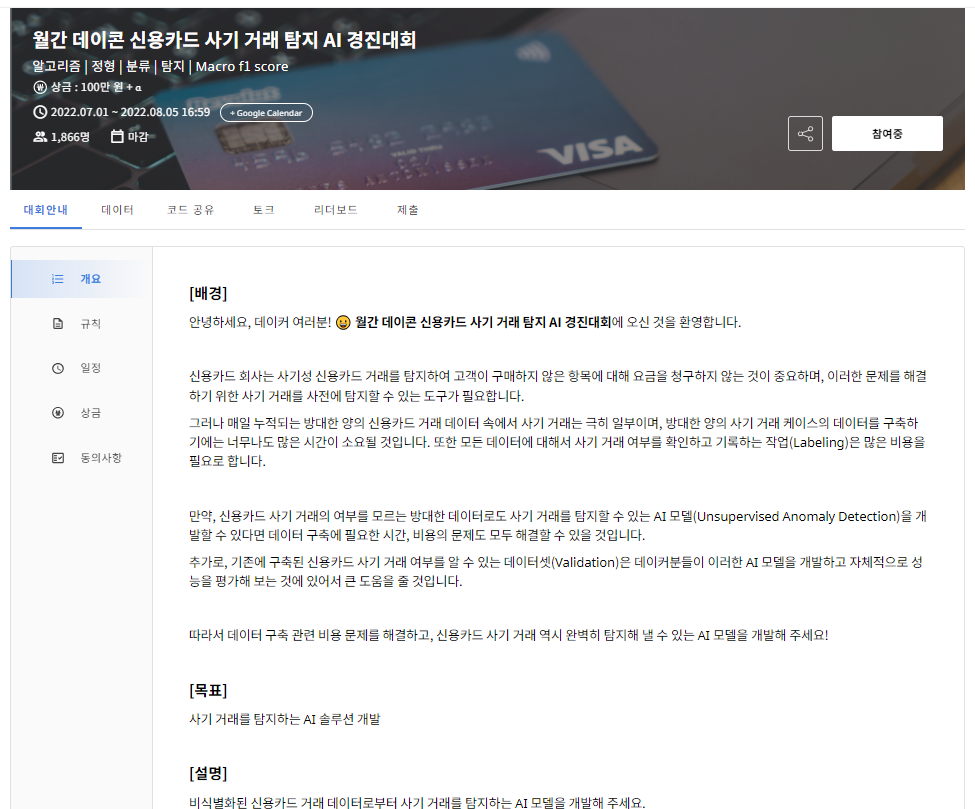

목표 : 불균형한 데이터에 대한 비지도 분류 학습

# Import

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## baseline
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/daicon/train.csv')
test = pd.read_csv('/content/drive/MyDrive/daicon/test.csv')
val = pd.read_csv('/content/drive/MyDrive/daicon/val.csv')

In [ ]:
train.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,3,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,4,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,6,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,8,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,9,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901


- ID : 신용 카드 거래 ID  
- Class : 신용카드 거래 정상, 사기 여부
  - 정상 : 0, 사기 : 1

# EDA

### 결측치 확인

In [ ]:
display(train.isnull().sum(),
        val.isnull().sum(),
        test.isnull().sum())

ID     0
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
dtype: int64

ID       0
V1       0
V2       0
V3       0
V4       0
V5       0
V6       0
V7       0
V8       0
V9       0
V10      0
V11      0
V12      0
V13      0
V14      0
V15      0
V16      0
V17      0
V18      0
V19      0
V20      0
V21      0
V22      0
V23      0
V24      0
V25      0
V26      0
V27      0
V28      0
V29      0
V30      0
Class    0
dtype: int64

ID     0
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
dtype: int64

결측치 없음  

### 데이터 개수

In [ ]:
print(train.shape, test.shape, val.shape)

(113842, 31) (142503, 31) (28462, 32)


- train : 113842  
- test : 142503  
- val : 28462  

**Train data**  
- 정상, 사기 여부 unlabeled  
- ID, 비식별화된 feature 30개  

**Validation data**  
- 정상, 사기 여부 labeled  
- ID, 비식별화된 feature 30개, Class  

**Test data**  
- 정상, 사기여부 unlabeled  
- ID, 비식별화된 feature 30개  

In [ ]:
train.describe()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
count,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,...,113842.000000,1.138420e+05,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000
mean,142025.527837,0.000197,0.001289,0.009717,-0.004169,0.000475,0.005141,0.005769,-0.002451,-0.002107,...,-0.001242,4.088347e-07,-0.001317,-0.000884,0.001680,-0.000293,-0.000234,-0.000508,0.927253,0.116232
std,82248.545392,1.951060,1.651064,1.496916,1.412633,1.367533,1.330583,1.204111,1.185504,1.095415,...,0.722001,7.238291e-01,0.636061,0.605854,0.520069,0.480979,0.399505,0.356130,3.412933,0.558161
min,3.000000,-56.407510,-72.715728,-32.454198,-5.600607,-42.147898,-26.160506,-41.506796,-50.943369,-13.434066,...,-22.757540,-8.887017e+00,-44.807735,-2.824849,-10.295397,-1.855355,-9.895244,-9.617915,-0.307413,-0.994972
25%,70796.750000,-0.923479,-0.595602,-0.883877,-0.853728,-0.689853,-0.766094,-0.552071,-0.209492,-0.647477,...,-0.229710,-5.402665e-01,-0.162180,-0.355582,-0.315470,-0.326160,-0.070847,-0.053249,-0.230560,-0.360304
50%,141722.000000,0.012074,0.066390,0.183868,-0.019359,-0.054060,-0.272436,0.039036,0.020970,-0.052157,...,-0.030281,8.345807e-03,-0.012261,0.040573,0.018278,-0.052815,0.001502,0.011158,-0.000699,-0.002590
75%,213359.500000,1.315373,0.801687,1.037120,0.742208,0.614214,0.405285,0.568750,0.328303,0.590705,...,0.186001,5.287508e-01,0.147474,0.438225,0.353989,0.240838,0.091279,0.077851,0.768532,0.640653
max,284803.000000,2.454930,21.467203,4.187811,16.491217,34.801666,23.917837,44.054461,20.007208,10.392889,...,27.202839,8.361985e+00,22.528412,4.022866,7.519589,3.119295,11.135740,33.847808,180.101027,1.034951


In [ ]:
test.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
count,142503.000000,142503.000000,142503.000000,142503.000000,142503.000000,142503.000000,142503.000000,142503.000000,142503.000000,142503.000000,...,142503.000000,142503.000000,142503.000000,142503.000000,142503.000000,142503.000000,142503.000000,142503.000000,142503.000000,142503.000000
mean,-0.001150,-0.001432,-0.008045,0.002953,0.000413,-0.000566,-0.005718,0.000156,0.002663,-0.003703,...,0.000990,-0.000245,0.000755,0.000436,-0.001799,0.000131,0.000291,0.000459,0.927643,0.120857
std,1.970325,1.660569,1.534737,1.420579,1.399096,1.341445,1.276403,1.218598,1.102741,1.103475,...,0.750835,0.728063,0.622160,0.605976,0.521118,0.482710,0.408738,0.312964,3.587433,0.557624
min,-46.855047,-63.344698,-48.325589,-5.683171,-113.743307,-21.929312,-43.557242,-73.216718,-13.320155,-24.588262,...,-34.830382,-10.933144,-36.666000,-2.836627,-7.081325,-2.604551,-22.565679,-15.430084,-0.307413,-0.994983
25%,-0.918999,-0.601184,-0.897737,-0.843486,-0.691653,-0.768976,-0.557038,-0.207301,-0.639999,-0.535903,...,-0.228032,-0.544174,-0.161839,-0.354442,-0.317557,-0.327252,-0.070642,-0.052847,-0.228044,-0.356712
50%,0.020709,0.063302,0.177372,-0.019912,-0.054976,-0.274172,0.039709,0.023347,-0.048317,-0.093491,...,-0.028912,0.005412,-0.010199,0.041524,0.015344,-0.051785,0.001390,0.011157,0.000000,0.003665
75%,1.316016,0.805219,1.022959,0.745448,0.612851,0.397152,0.572513,0.327192,0.601995,0.453073,...,0.186605,0.528426,0.148161,0.440355,0.347873,0.241060,0.091201,0.078123,0.772375,0.642741
max,2.446505,22.057729,9.382558,16.875344,32.911462,73.301626,120.589494,19.587773,15.594995,23.745136,...,27.202839,10.503090,22.083545,4.584549,6.070850,3.517346,31.612198,15.870474,358.683155,1.035022


In [ ]:
val.describe()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
count,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,...,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000
mean,142549.840138,0.004967,0.002014,0.001414,0.001893,-0.003969,-0.017730,0.005556,0.009023,-0.004905,...,0.001224,0.001490,0.001355,0.002284,0.000520,-0.000520,-0.000265,0.924010,0.119916,0.001054
std,82252.851474,1.930640,1.605198,1.499749,1.405139,1.335147,1.292214,1.165132,1.103538,1.090843,...,0.721350,0.588076,0.603181,0.526864,0.484804,0.394235,0.304284,3.347555,0.558246,0.032449
min,10.000000,-29.516123,-38.305310,-30.177317,-5.071241,-21.577019,-16.172614,-31.197329,-26.278007,-9.462573,...,-8.555808,-25.356744,-2.807897,-6.035054,-1.596493,-9.793568,-8.364853,-0.307413,-0.994878,0.000000
25%,71260.000000,-0.915525,-0.598053,-0.873022,-0.852444,-0.698010,-0.774920,-0.546290,-0.210941,-0.642760,...,-0.542624,-0.160418,-0.352310,-0.322098,-0.328638,-0.071787,-0.052361,-0.226927,-0.357884,0.000000
50%,142683.500000,0.023586,0.075470,0.175784,-0.021619,-0.052780,-0.280742,0.046280,0.022622,-0.066623,...,0.008401,-0.011372,0.040076,0.016684,-0.049583,0.000488,0.012138,0.005589,0.002156,0.000000
75%,213612.750000,1.315578,0.803463,1.011563,0.739044,0.598712,0.377266,0.566825,0.323836,0.596308,...,0.528163,0.146094,0.441402,0.352930,0.241051,0.089100,0.080822,0.778278,0.641828,0.000000
max,284806.000000,2.411769,16.497472,4.226108,12.114672,24.345310,12.128950,26.237722,12.431140,7.937413,...,6.090514,18.946734,3.658746,5.525093,3.067907,8.708972,15.726807,165.948299,1.034975,1.000000


- 변수별로 min, max 값의 차이가 매우 큼  
- 뒤에 나오는 변수별 히스토그램에서도 각 변수별로 값의 폭이 다양  
=> **scaling 및 정규화 고려**

### val data 이상치, 정상치 비율  

In [ ]:
len(val[val['Class']==0])

28432

In [ ]:
len(val[val['Class']==1])

30

- validation 중에서 정상치는 28432개, 이상치는 30개가 있음  
=> 사기 거래 건수가 매우 현저히 적음



## Train

### 분포 확인

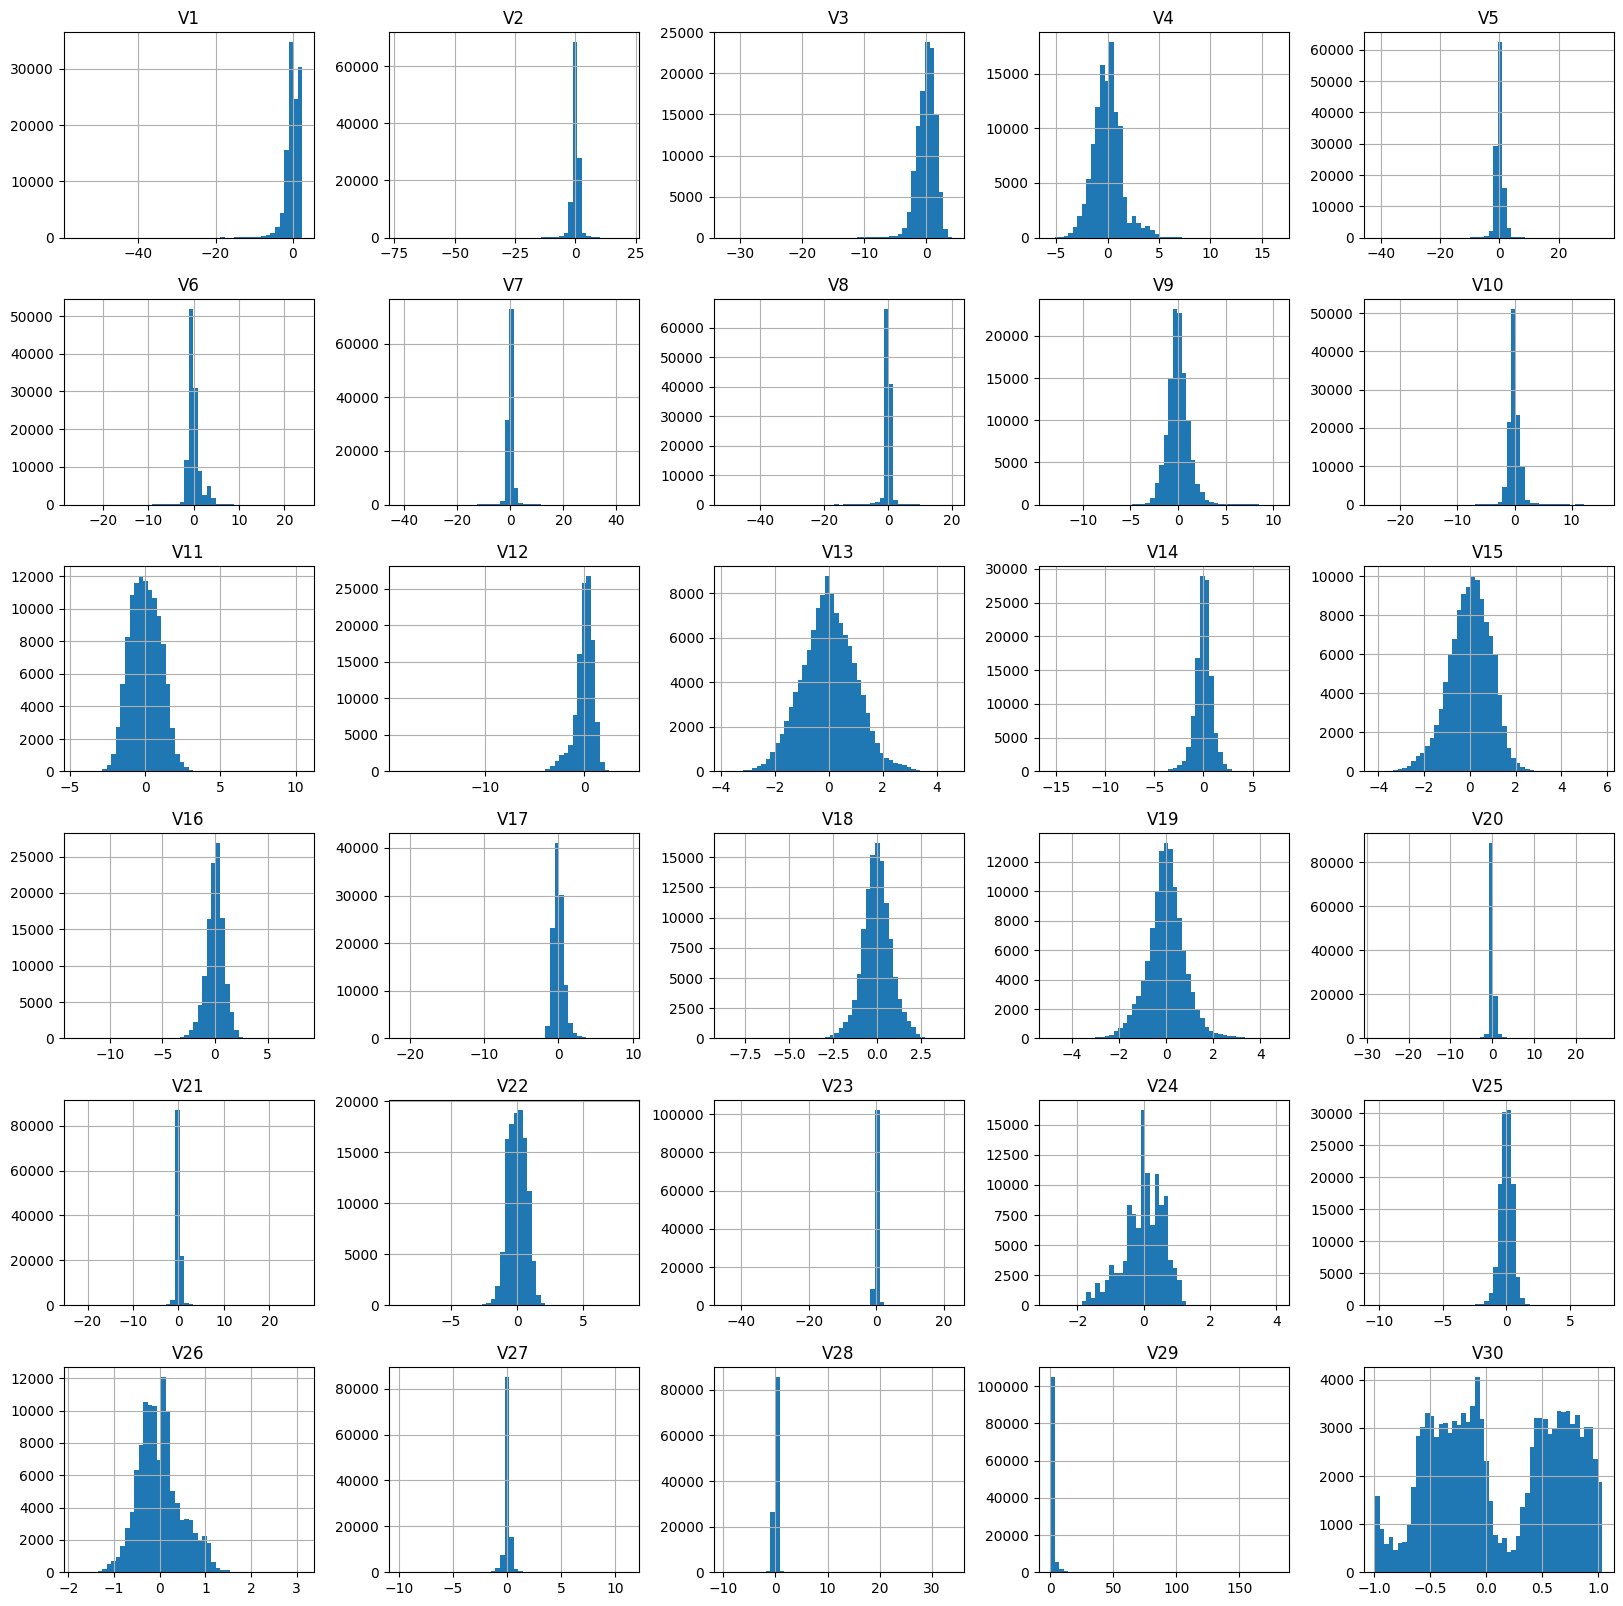

In [ ]:
train.drop(columns=['ID']).hist(bins = 50, figsize = (20,20))
plt.show()

### 변수 간 상관관계 파악  

<Axes: >

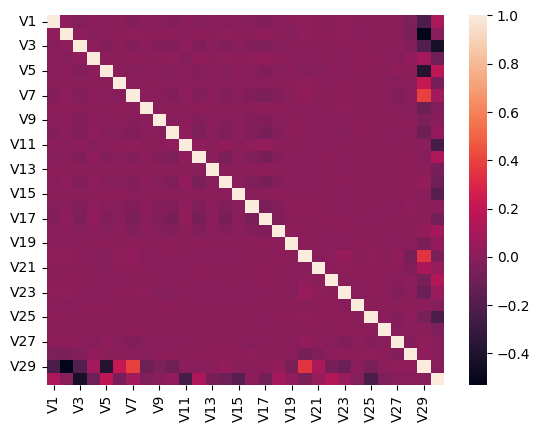

In [ ]:
sns.heatmap(train.loc[:,train.columns != 'ID'].corr())

In [ ]:
train.loc[:,train.columns != 'ID'].corr()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
V1,1.000000,0.015507,-0.015559,0.005334,-0.009902,-0.000177,-0.021839,0.003626,-0.009599,-0.019278,...,0.000829,-0.001097,0.017551,-0.001289,0.002329,-0.002013,0.004085,-0.044459,-0.231744,0.118519
V2,0.015507,1.000000,0.015350,-0.004632,0.005220,0.004119,0.020025,0.002628,0.001865,0.011013,...,0.010194,0.003269,0.015923,-0.004967,-0.003145,0.000796,0.005265,-0.056137,-0.530737,-0.008336
V3,-0.015559,0.015350,1.000000,0.014562,-0.021869,-0.000392,-0.023424,0.002836,-0.017386,-0.028125,...,-0.001319,0.004616,0.001575,0.003254,0.000031,0.000671,0.003680,-0.022925,-0.207185,-0.429787
V4,0.005334,-0.004632,0.014562,1.000000,0.009886,0.001191,0.011269,0.000271,0.008993,0.015209,...,-0.000008,-0.002732,-0.004866,0.001741,0.001838,0.002832,-0.007131,0.025828,0.091913,-0.103017
V5,-0.009902,0.005220,-0.021869,0.009886,1.000000,-0.000701,-0.012571,-0.000730,-0.006367,-0.015695,...,-0.013559,0.004033,-0.009856,0.004302,-0.001611,-0.000664,0.020649,-0.004484,-0.382747,0.175038
V6,-0.000177,0.004119,-0.000392,0.001191,-0.000701,1.000000,-0.010017,0.008153,-0.004149,-0.008792,...,0.006419,-0.004982,0.004990,-0.001185,-0.000470,-0.003615,-0.011486,0.000046,0.210381,-0.061977
V7,-0.021839,0.020025,-0.023424,0.011269,-0.012571,-0.010017,1.000000,0.000813,-0.009075,-0.033170,...,0.008721,-0.000123,0.011034,-0.001084,0.000420,0.004651,-0.033952,0.006749,0.391239,0.084646
V8,0.003626,0.002628,0.002836,0.000271,-0.000730,0.008153,0.000813,1.000000,-0.003052,-0.001326,...,0.001672,0.000508,0.013885,0.000094,-0.003231,0.003217,-0.006134,-0.014922,-0.102777,-0.036350
V9,-0.009599,0.001865,-0.017386,0.008993,-0.006367,-0.004149,-0.009075,-0.003052,1.000000,-0.009130,...,-0.007212,-0.002725,-0.008715,0.002114,-0.001449,0.001348,-0.001733,0.008454,-0.041503,-0.007580
V10,-0.019278,0.011013,-0.028125,0.015209,-0.015695,-0.008792,-0.033170,-0.001326,-0.009130,1.000000,...,-0.006280,0.001598,-0.015512,0.004706,-0.000694,-0.000581,-0.005133,0.002669,-0.103121,0.029717


In [ ]:
## 양의 상관계수 중에서 큰 값을 반환
def corr_largest_positive(df, num=5):
  df_corr = df.loc[:, df.columns != 'ID'].corr() # 상관계수
  np.fill_diagonal(df_corr.values, 0) # 대각성분 0으로 채움

  largest_values = np.partition(df_corr.values.flatten(), -num)[-num:]

  # 상위 큰 값들에 해당하는 인덱스를 찾음
  indices = np.where(df_corr.values >= largest_values.min())

  # 해당 변수 쌍과 큰 값들을 가져옴
  top_variable_pairs = []
  for row_idx, col_idx in zip(*indices):
    if row_idx != col_idx:
        top_variable_pairs.append((
            df_corr.columns[row_idx],
            df_corr.columns[col_idx],
            df_corr.values[row_idx, col_idx]
        ))

  # 큰 값이 큰 순서대로 정렬
  top_variable_pairs.sort(key=lambda x: x[2], reverse=True)

  return top_variable_pairs

In [ ]:
## 음의 상관계수 중에서 작은 값 반환(상관계수 힘이 큰?)

def zero_positive_values(x): # 0보다 크거나 같으면 0으로 바꿈
  return 100 if x >= 0 else x

def corr_largest_negative(df, num=5):
  df_corr = df.loc[:, df.columns != 'ID'].corr() # 상관계수
  np.fill_diagonal(df_corr.values, 0) # 대각성분 0으로 채움

  df_corr = df_corr.applymap(zero_positive_values)

  smallest_values = np.partition(df_corr.values.flatten(), num - 1)[:num]

  indices = np.where(df_corr.values <= smallest_values.max())

  top_variable_pairs = []
  for row_idx, col_idx in zip(*indices):
    if row_idx != col_idx:
        top_variable_pairs.append((
            df_corr.columns[row_idx],
            df_corr.columns[col_idx],
            df_corr.values[row_idx, col_idx]
        ))

  top_variable_pairs.sort(key=lambda x: x[2], reverse=False)

  return top_variable_pairs

In [ ]:
corr_largest_positive(train,10)

[('V7', 'V29', 0.3912394217704034),
 ('V29', 'V7', 0.3912394217704034),
 ('V20', 'V29', 0.34821926368980743),
 ('V29', 'V20', 0.34821926368980743),
 ('V6', 'V29', 0.21038122045218996),
 ('V29', 'V6', 0.21038122045218996),
 ('V5', 'V30', 0.17503843463847807),
 ('V30', 'V5', 0.17503843463847807),
 ('V22', 'V30', 0.1442500129399404),
 ('V30', 'V22', 0.1442500129399404)]

In [ ]:
corr_largest_negative(train,10)

[('V2', 'V29', -0.5307373283987125),
 ('V29', 'V2', -0.5307373283987125),
 ('V3', 'V30', -0.4297866482472323),
 ('V30', 'V3', -0.4297866482472323),
 ('V5', 'V29', -0.3827470659254894),
 ('V29', 'V5', -0.3827470659254894),
 ('V11', 'V30', -0.24705122496555065),
 ('V30', 'V11', -0.24705122496555065),
 ('V1', 'V29', -0.23174390017439658),
 ('V29', 'V1', -0.23174390017439658)]

- 양의 상관계수가 가장 큰 변수 쌍 : (V7, V29), (V20, V29), (V6, V29), (V5, V30), (V22, V30)  
- 음의 상관계수가 가장 큰 변수 쌍(?) : (V2, V29), (V3, V30), (V5, V29), (V11, V30), (V1, V29)

In [ ]:
def scatter_plot(data, x, y, hue):
  corr = np.corrcoef(data[x], data[y])[0,1]
  print(f'\n상관계수 :{corr}\n')

  fig, ax = plt.subplots(figsize=(10,6))
  sns.scatterplot(data=data, x=x, y=y, hue=hue)
  ax.set_title(f"{x} & {y} Scatter")


상관계수 :0.39123942177039084



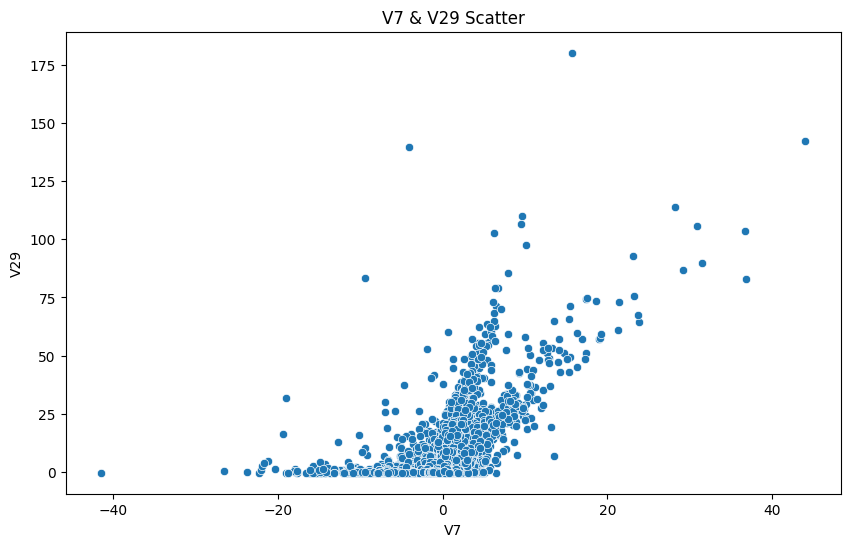

In [ ]:
scatter_plot(train, 'V7', 'V29', None)


상관계수 :-0.5307373283987076



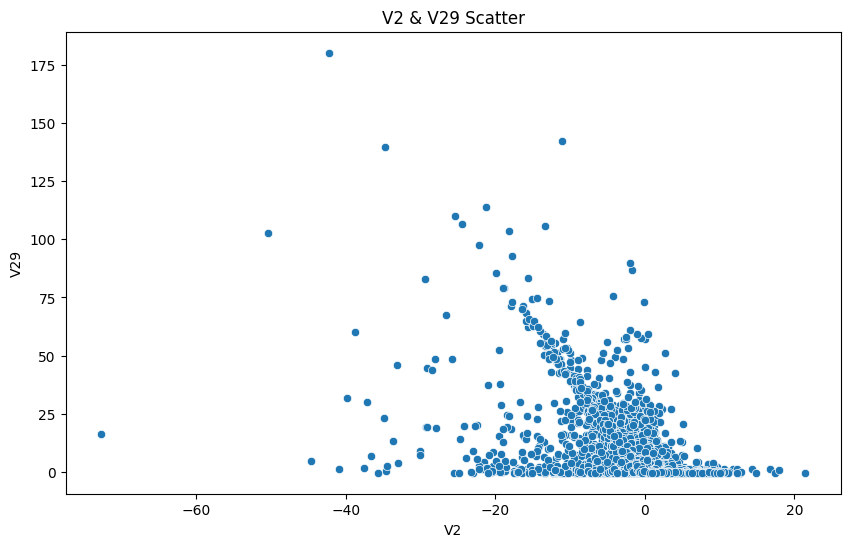

In [ ]:
scatter_plot(train, 'V2', 'V29', None)

## Val

### 분포 확인

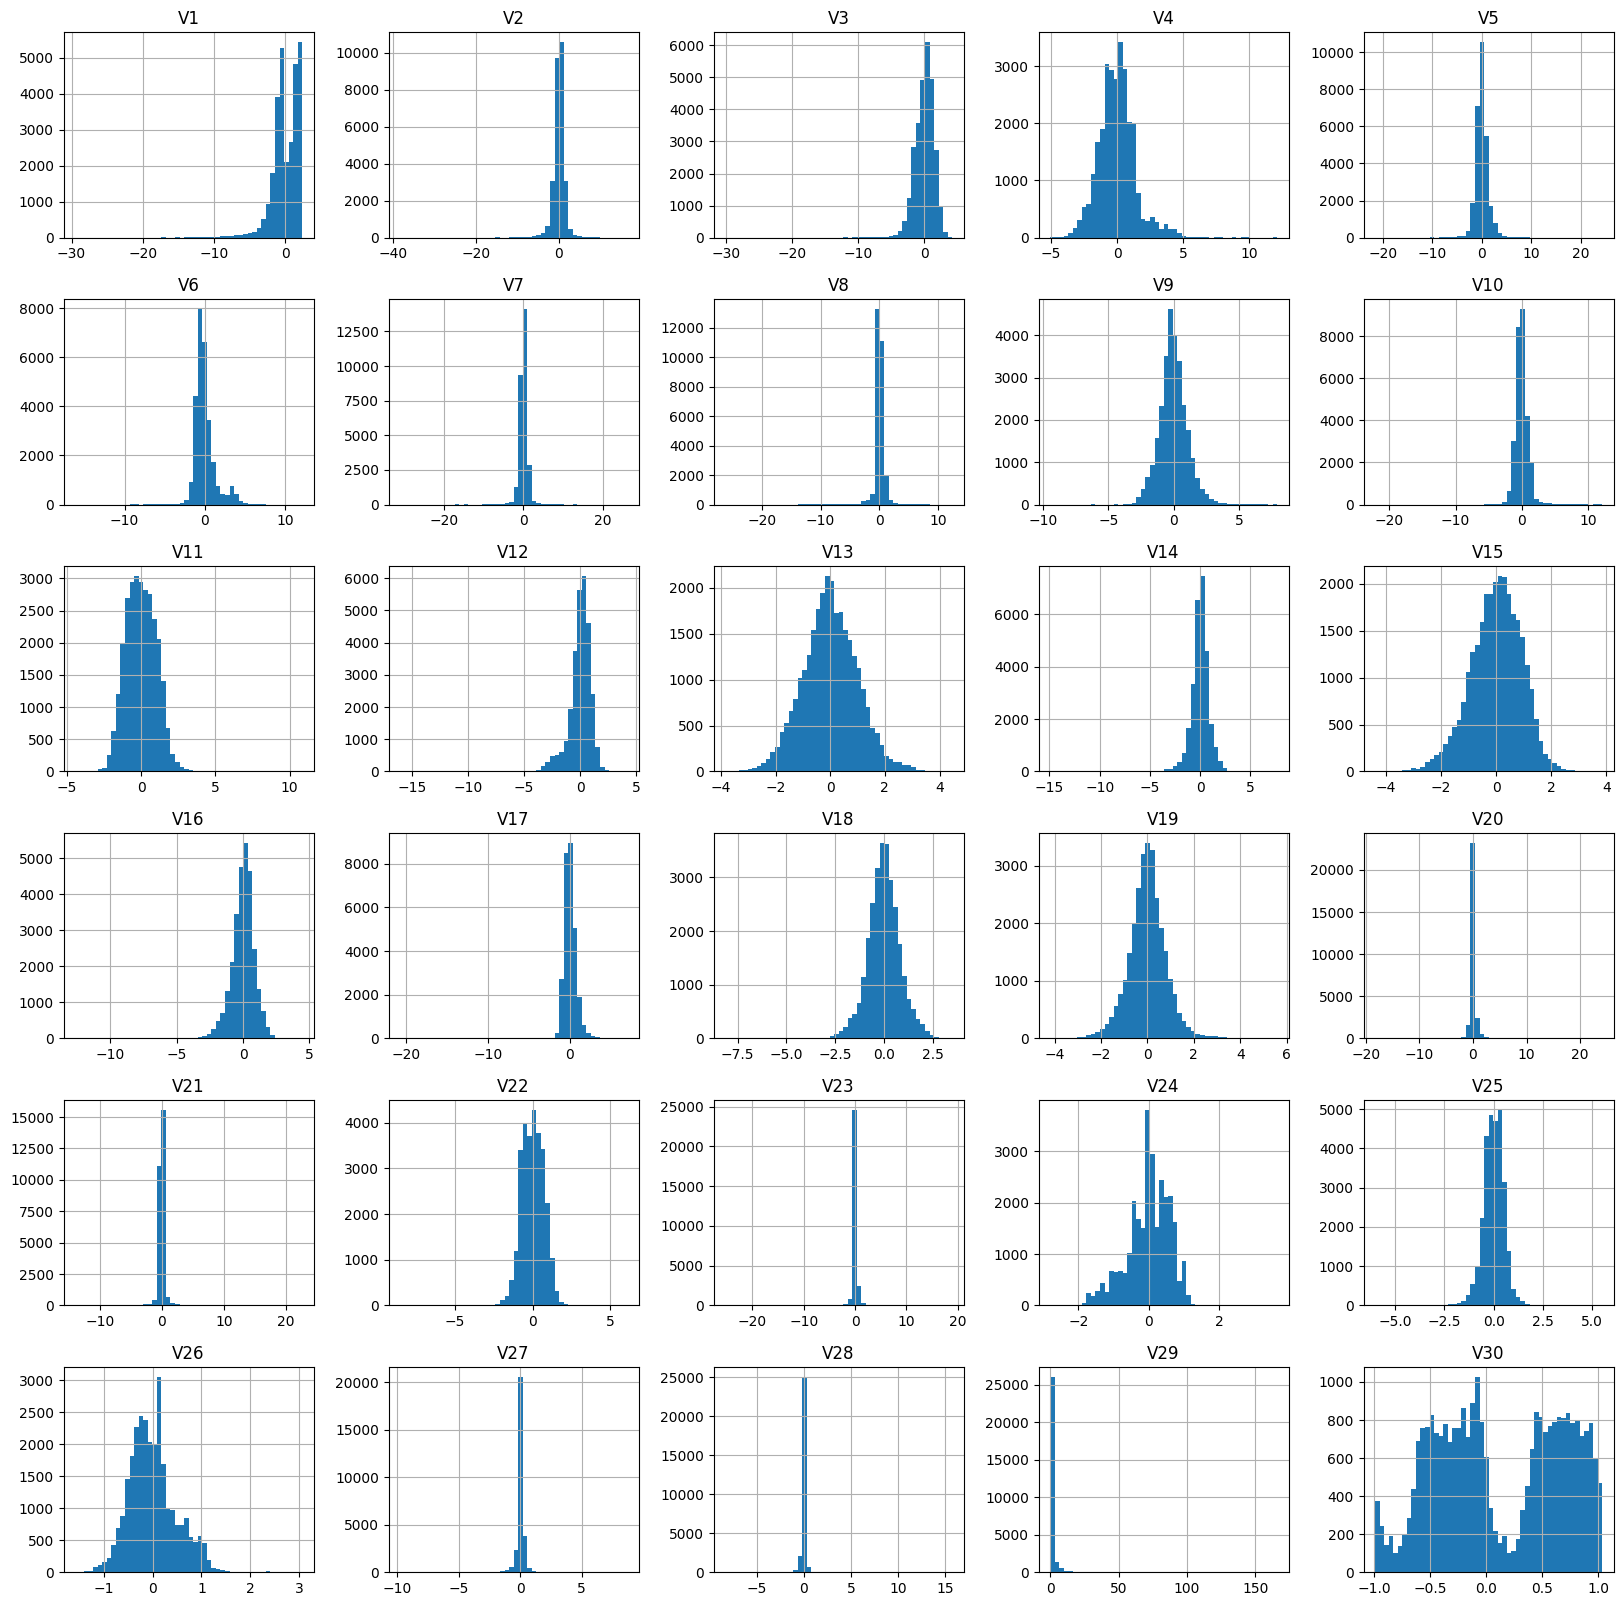

In [ ]:
val.drop(columns=['ID','Class']).hist(bins = 50, figsize = (20,20))
plt.show()

### 변수 간 상관관계 파악

In [ ]:
val.columns

Index(['ID', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30',
       'Class'],
      dtype='object')

<Axes: >

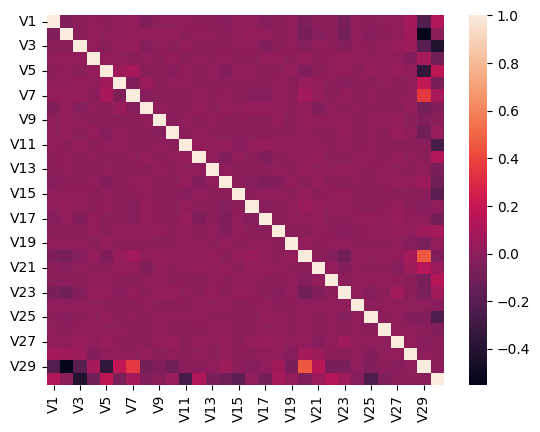

In [ ]:
sns.heatmap(val.loc[:,(val.columns != 'ID')&(val.columns !='Class')].corr())

In [ ]:
## 양의 상관계수 중에서 큰 값을 반환
def corr_largest_positive_val(df, num=5):
  df_corr = df.loc[:, (df.columns != 'ID')&(df.columns !='Class')].corr() # 상관계수
  np.fill_diagonal(df_corr.values, 0) # 대각성분 0으로 채움

  largest_values = np.partition(df_corr.values.flatten(), -num)[-num:]

  # 상위 큰 값들에 해당하는 인덱스를 찾음
  indices = np.where(df_corr.values >= largest_values.min())

  # 해당 변수 쌍과 큰 값들을 가져옴
  top_variable_pairs = []
  for row_idx, col_idx in zip(*indices):
    if row_idx != col_idx:
        top_variable_pairs.append((
            df_corr.columns[row_idx],
            df_corr.columns[col_idx],
            df_corr.values[row_idx, col_idx]
        ))

  # 큰 값이 큰 순서대로 정렬
  top_variable_pairs.sort(key=lambda x: x[2], reverse=True)

  return top_variable_pairs

In [ ]:
## 음의 상관계수 중에서 작은 값 반환(상관계수 힘이 큰?)

def zero_positive_values(x): # 0보다 크거나 같으면 0으로 바꿈
  return 100 if x >= 0 else x

def corr_largest_negative_val(df, num=5):
  df_corr = df.loc[:, (df.columns != 'ID')&(df.columns !='Class')].corr() # 상관계수
  np.fill_diagonal(df_corr.values, 0) # 대각성분 0으로 채움

  df_corr = df_corr.applymap(zero_positive_values)

  smallest_values = np.partition(df_corr.values.flatten(), num - 1)[:num]

  indices = np.where(df_corr.values <= smallest_values.max())

  top_variable_pairs = []
  for row_idx, col_idx in zip(*indices):
    if row_idx != col_idx:
        top_variable_pairs.append((
            df_corr.columns[row_idx],
            df_corr.columns[col_idx],
            df_corr.values[row_idx, col_idx]
        ))

  top_variable_pairs.sort(key=lambda x: x[2], reverse=False)

  return top_variable_pairs

In [ ]:
val.loc[:,(val.columns != 'ID')&(val.columns !='Class')].corr()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
V1,1.000000,-0.038475,-0.014799,0.011677,-0.002571,0.004865,0.013540,-0.044240,0.003845,0.005688,...,-0.010817,-0.014931,-0.064017,0.005608,-0.016073,0.000287,0.006761,0.076969,-0.217527,0.123897
V2,-0.038475,1.000000,-0.012623,0.016345,0.002036,0.004739,0.018912,0.024011,0.013742,0.019898,...,-0.024494,-0.004731,-0.094970,0.002928,-0.018242,-0.002026,0.000506,0.065031,-0.551569,-0.012744
V3,-0.014799,-0.012623,1.000000,0.014576,-0.012741,0.016019,0.028041,-0.028748,0.003331,-0.006199,...,0.003189,-0.011808,-0.031689,0.006090,-0.001454,0.006596,0.031787,0.051008,-0.188678,-0.415954
V4,0.011677,0.016345,0.014576,1.000000,0.013701,0.001960,-0.009758,0.000173,-0.001150,0.014927,...,-0.006039,0.008993,0.024209,0.000229,0.001749,0.000468,0.003416,-0.036356,0.084962,-0.105869
V5,-0.002571,0.002036,-0.012741,0.013701,1.000000,0.055214,0.091640,-0.014929,-0.014733,-0.020577,...,-0.014673,0.011737,0.016742,-0.010241,0.018782,0.005571,0.033141,0.010778,-0.350229,0.173559
V6,0.004865,0.004739,0.016019,0.001960,0.055214,1.000000,-0.045892,0.046400,-0.004506,0.006566,...,0.017662,-0.005287,-0.020681,-0.002925,-0.014474,0.001783,-0.006311,0.001205,0.182177,-0.065672
V7,0.013540,0.018912,0.028041,-0.009758,0.091640,-0.045892,1.000000,-0.026837,-0.015528,-0.014559,...,0.028630,-0.014162,0.017168,-0.010401,0.002938,-0.002487,-0.011901,0.006016,0.357186,0.087822
V8,-0.044240,0.024011,-0.028748,0.000173,-0.014929,0.046400,-0.026837,1.000000,0.009756,-0.000044,...,-0.039327,0.005441,-0.005806,0.001078,-0.011417,-0.002057,-0.003654,0.022818,-0.089362,-0.034963
V9,0.003845,0.013742,0.003331,-0.001150,-0.014733,-0.004506,-0.015528,0.009756,1.000000,-0.018484,...,0.007371,0.005980,0.020509,-0.017849,0.008199,0.000522,0.017762,-0.016028,-0.045190,-0.017037
V10,0.005688,0.019898,-0.006199,0.014927,-0.020577,0.006566,-0.014559,-0.000044,-0.018484,1.000000,...,-0.002758,-0.006723,0.020750,-0.001398,0.005013,-0.002825,0.038079,0.004382,-0.103905,0.032005


In [ ]:
corr_largest_positive_val(val,10)

[('V20', 'V29', 0.4596596989945927),
 ('V29', 'V20', 0.4596596989945927),
 ('V7', 'V29', 0.35718618574409294),
 ('V29', 'V7', 0.35718618574409294),
 ('V6', 'V29', 0.18217673620400643),
 ('V29', 'V6', 0.18217673620400643),
 ('V5', 'V30', 0.17355934728572103),
 ('V30', 'V5', 0.17355934728572103),
 ('V21', 'V29', 0.14720455577640035),
 ('V29', 'V21', 0.14720455577640035)]

In [ ]:
corr_largest_negative_val(val,10)

[('V2', 'V29', -0.5515689871996198),
 ('V29', 'V2', -0.5515689871996198),
 ('V3', 'V30', -0.4159537241625202),
 ('V30', 'V3', -0.4159537241625202),
 ('V5', 'V29', -0.35022910274700036),
 ('V29', 'V5', -0.35022910274700036),
 ('V11', 'V30', -0.2619628193959369),
 ('V30', 'V11', -0.2619628193959369),
 ('V25', 'V30', -0.2310186592850482),
 ('V30', 'V25', -0.2310186592850482)]

- 양의 상관계수가 가장 큰 변수 쌍 : (V20, V29), (V7, V29), (V6, V29), (V5, V30), (V21, V29)
- 음의 상관계수가 가장 큰 변수 쌍(?) : (V2, V29), (V3, V30), (V5, V29), (V11, V30), (V25, V30)


상관계수 :0.45965969899458936



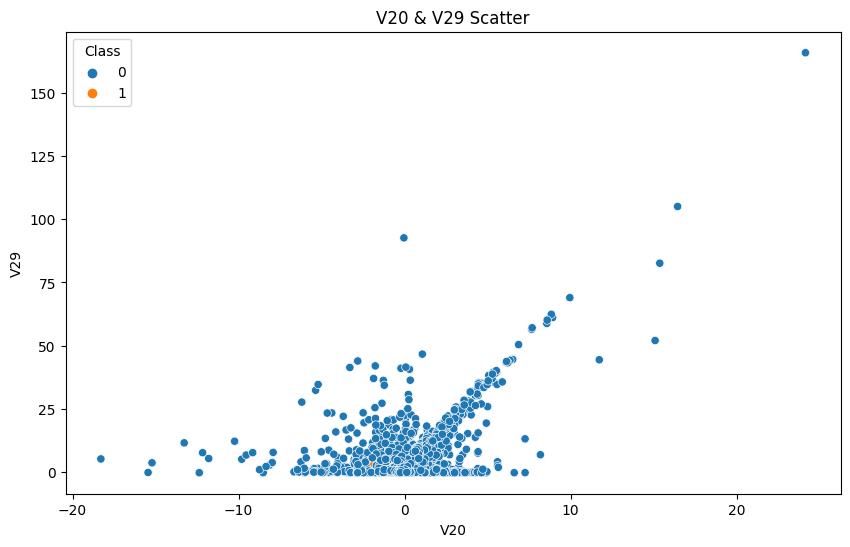

In [ ]:
scatter_plot(val, 'V20', 'V29', 'Class')


상관계수 :-0.5515689871996157



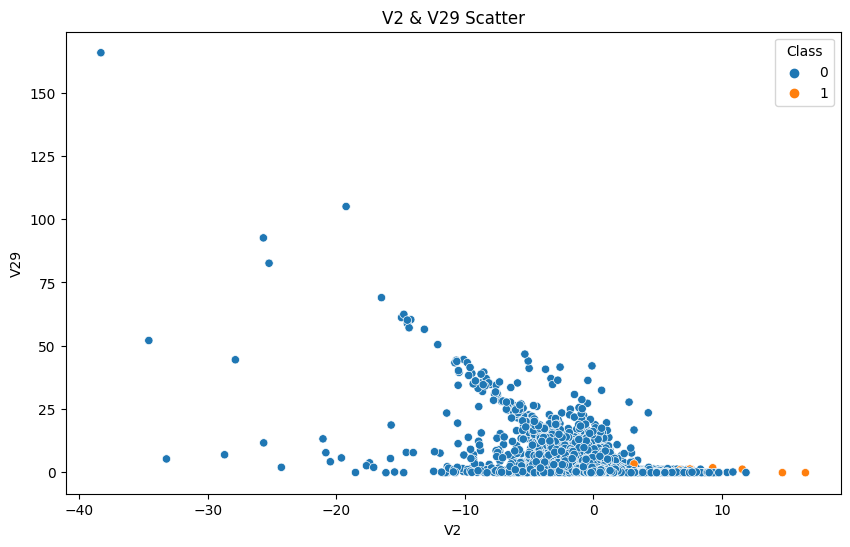

In [ ]:
scatter_plot(val, 'V2', 'V29', 'Class')

# 모델 학습

## Baseline model - Isolation Forest



In [ ]:
train_df = train
val_df = val

In [ ]:
val_normal, val_fraud = val_df['Class'].value_counts() # 정상치, 이상치
val_contamination = val_fraud / val_normal
print(f'Validation contamination : [{val_contamination}]')

Validation contamination : [0.0010551491277433877]


※ validation data의 이상치 비율이 다른 데이터 집합에서도 비슷하게 발생할 것이라 가정  

### Modeling

In [ ]:
train_x = train_df.drop(columns=['ID']) # train에 label 존재x

In [ ]:
model = IsolationForest(n_estimators=125, max_samples=len(train_x), contamination=val_contamination, random_state=42, verbose=0)
model.fit(train_x)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.0010551491277433877, max_samples=113842,
                n_estimators=125, random_state=42)

**IsolationForest**  
- Unsupervised Anaomaly Detection 중 하나로, 이상치 탐지할 때 주로 사용    
- Regression tree 기반의 split으로 모든 데이터 관측치를 고립시키는 방법  
  - **비정상 데이터**가 고립되려면, 루트 노드와 가까운 depth를 가짐  
  - **정상 데이터**가 고립되려면, 말단 노드에 가까운 depth를 가짐  
- 특정 한 개체가 고립되는 말단 노드 까지의 거리를 **outlier score**로 정의  
  - 평균 거리가 짧을수록 outlier score는 높아짐  
  <img src="https://i.imgur.com/rzP7siS.png" width="500" height="200">  


출처 : https://velog.io/@vvakki_/Isolation-Forest-%EB%AF%B8%EC%99%84%EC%84%B1, https://donghwa-kim.github.io/iforest.html  

### Evaluation : validation data

In [ ]:
def get_pred_label(model_pred):
  # IsolationForest 모델 출력 (1 : 정상, -1 : 사기) -> (0 : 정상, 1 : 사기) 변환
  model_pred = np.where(model_pred == 1, 0, model_pred)
  model_pred = np.where(model_pred == -1, 1, model_pred)
  return model_pred

In [ ]:
val_x = val_df.drop(columns=['ID','Class'])
val_y = val_df['Class']

val_pred = model.predict(val_x)

In [ ]:
set(val_pred) # (-1,1) -> (0,1) 변환

{-1, 1}

In [ ]:
val_pred = get_pred_label(val_pred)

In [ ]:
val_score = f1_score(val_y, val_pred, average='macro')

In [ ]:
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, val_pred))

Validation F1 Score : [0.7030820840915222]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.41      0.40      0.41        30

    accuracy                           1.00     28462
   macro avg       0.71      0.70      0.70     28462
weighted avg       1.00      1.00      1.00     28462



**Macro-F1 Score**  
- 클래스/레이블 별 F1 Score의 평균  
- 모든 클래스에 동등한 중요성 부여  
- 불균형한 데이터에 사용하기 적절  

### Inference : Test data

In [ ]:
test_df = test

In [ ]:
test_x = test_df.drop(columns=['ID'])

In [ ]:
test_pred = model.predict(test_x)
test_pred = get_pred_label(test_pred)

In [ ]:
test_pred # 각 데이터별로 예측한 class 값

array([0, 0, 0, ..., 0, 0, 0])

이후 일정  

- ~~Isolation Forest (Baseline model)~~
- K-Means  
- Autoencoder 등

기본적인 clustering modeling 예정!